In [47]:
from obspy import read
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [48]:
st = read("data\GUY2C_7_15_NOV.mseed")
st1 = st.select(channel='HHZ')
tr=st1[0]
for i in st1[1::]:
    tr=tr+i
tr=tr.filter('highpass', freq=1, corners=2, zerophase=True)

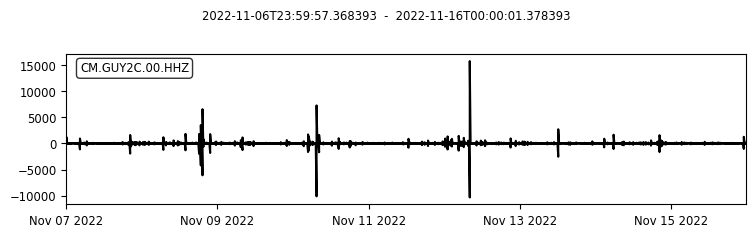

In [49]:
tr.plot();

In [50]:
def window(npr,dt,size,ovlp):
    ls=[]
    size=size/dt
    ovlp=((100-ovlp)/100)*size
    r0=0
    r1=int(size)
    for _ in range(0,int(len(tr.data)/ovlp)):
        ls.append(npr[r0:r1])
        r0=int(r0+ovlp)
        r1=int(r1+ovlp)
    return ls,ovlp
all,ovlp=window(tr.data,tr.stats.delta,60,80)
# all=all.filter('highpass', freq=1.0, corners=2, zerophase=True)

In [51]:
f=tr.stats.sampling_rate
dt=tr.stats.delta

In [52]:
std=[]
kur=[]
skewt=[]
skewf=[]
pkfreq=[]
prfreq=[]
for i in all:
    std.append(np.std(i))
    kur.append(kurtosis(i))
    skewt.append(skew(i))
    N = len(i)
    y = i
    fft_x = fft(y) / N # FFT Normalized
    freq = fftfreq(N, dt) # Recuperamos las frecuencias
    ampl=abs(fft_x[range(int(N/2))])
    freq=freq[range(int(N/2))]
    try:
        pkfreq.append(freq[ampl.argmax()][0])
    except:
        pkfreq.append(freq[ampl.argmax()])
    prfreq.append(freq[np.where(ampl == np.percentile(ampl,50,method='closest_observation'))[0]])
    skewf.append(skew(ampl))

In [53]:
df=pd.DataFrame()
for val,col in zip([all,std,kur,skewt,skewf,pkfreq,prfreq],['raw','std','kur','skewt','skewf','pkfreq','prfreq']):
    df[col]=val

In [66]:
wcss = []
silh = []
dbs  = []
ran1=2
ran2=10
for i in range(ran1,ran2):
    kmeans = KMeans( i, init = 'k-means++', random_state = 42)
    kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    dbs.append(davies_bouldin_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))
    silh.append(silhouette_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))

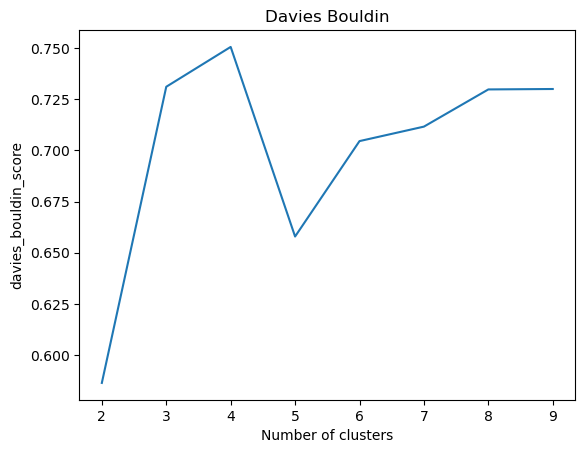

In [67]:
plt.plot(range(ran1,ran2), dbs)
plt.title('Davies Bouldin')
plt.xlabel('Number of clusters')
plt.ylabel('davies_bouldin_score')
plt.show()

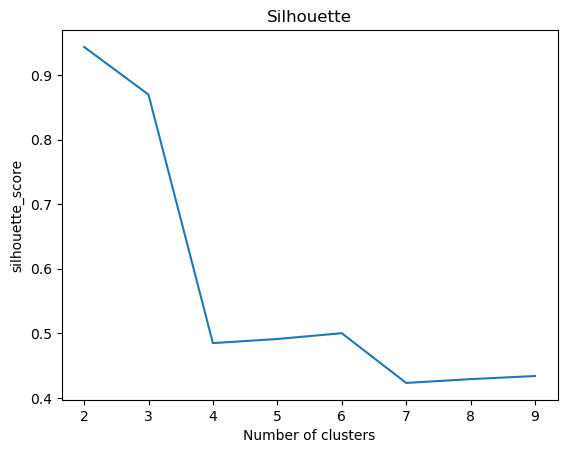

In [70]:
plt.plot(range(ran1,ran2), silh)
plt.title('Silhouette')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()

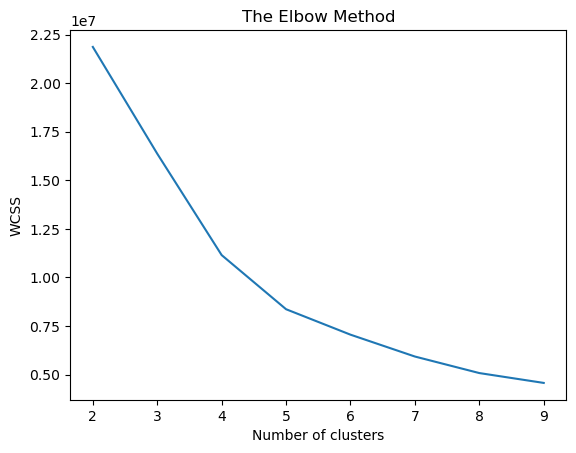

In [71]:
plt.plot(range(ran1,ran2), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [72]:
kmeans = KMeans(4, init = 'k-means++', random_state = 42)
kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
labels = kmeans.labels_
df['cluster']=labels

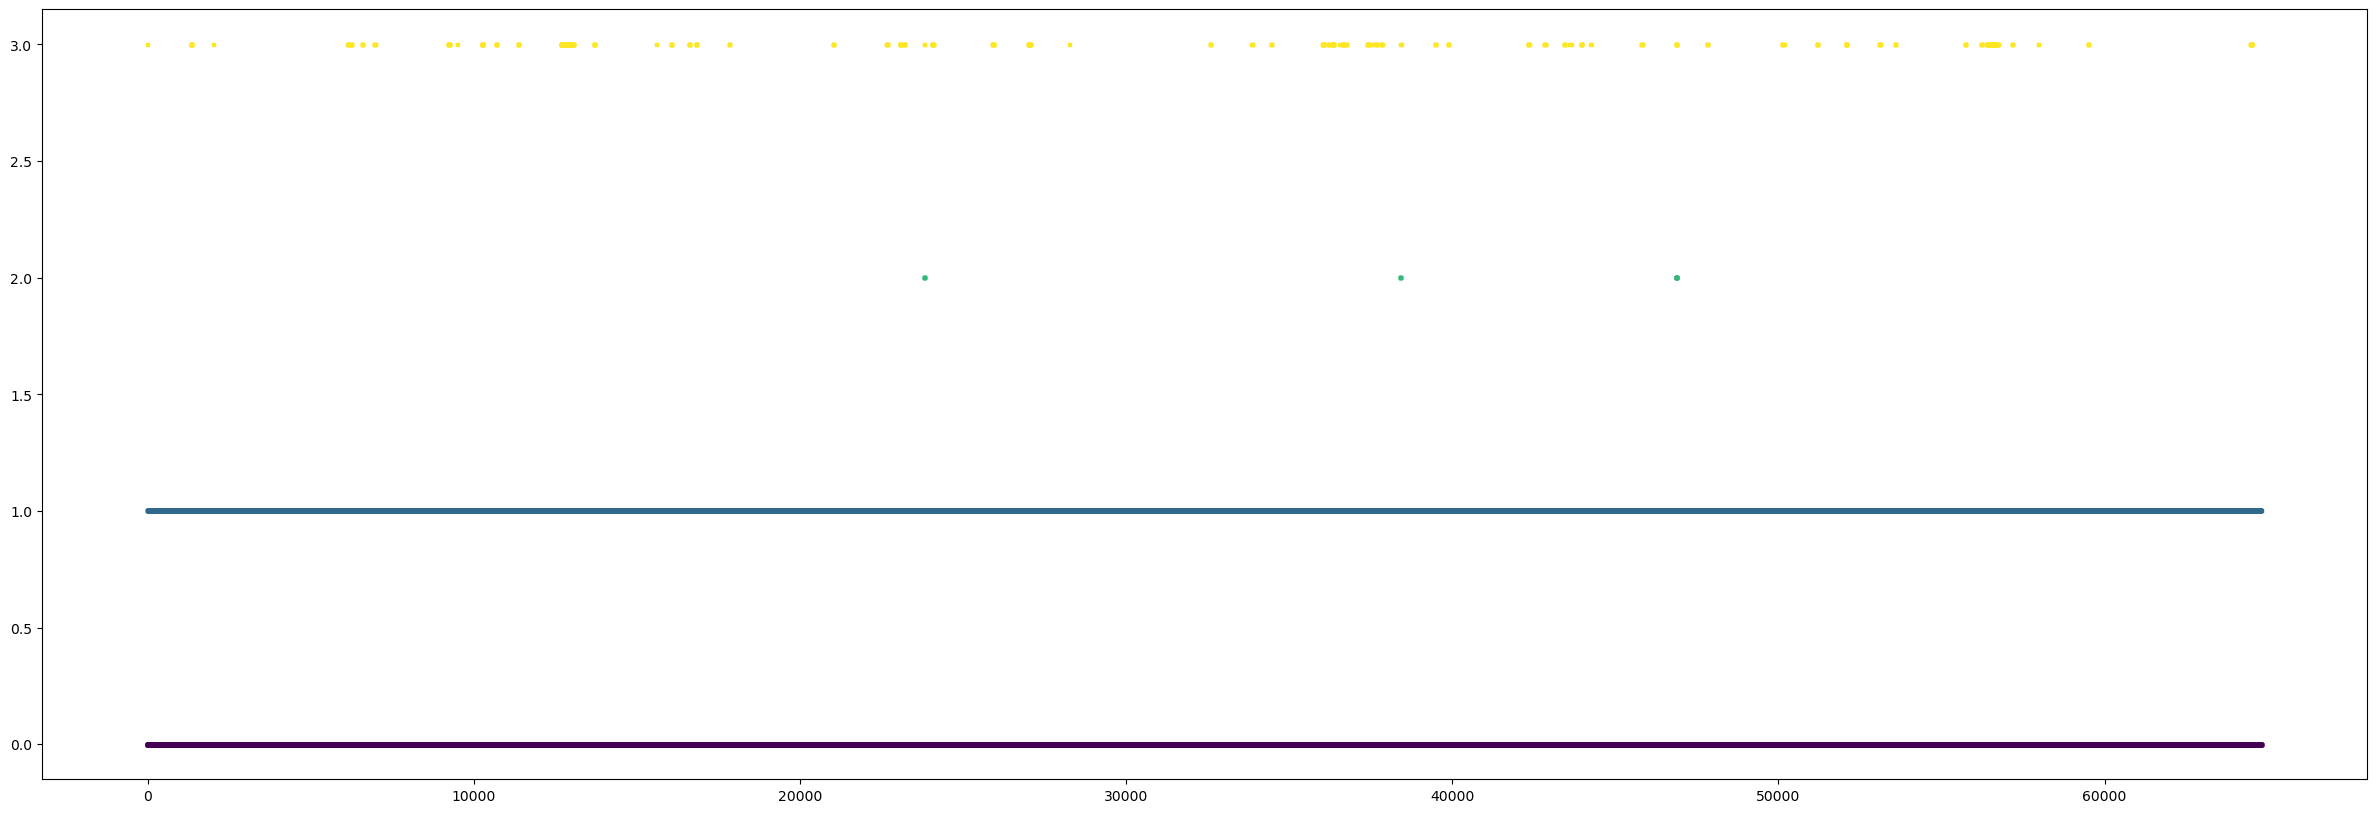

In [73]:
plt.figure(figsize=(30,10))
plt.scatter(range(0,len(df['cluster'])),df['cluster'],c=df['cluster'],s=5,marker='s')

In [74]:
hour=((3600/tr.stats.delta)/ovlp)-1
ran1=0
ran2=hour
ls_stats_hour=[]
for i in range(int((len(all))/((3600/tr.stats.delta)/ovlp))):
    df1=df.iloc[int(ran1):int(ran2+1),-1]
    ls_stats_hour.append(df1.value_counts().rename(i))
    ran1+=hour
    ran2+=hour
stats=pd.concat(ls_stats_hour,axis=1)
stats=stats.replace(np.nan,0)

In [75]:
init=11
ls=[0]
for i in range(19):
    ls.append(init)
    init=init+12

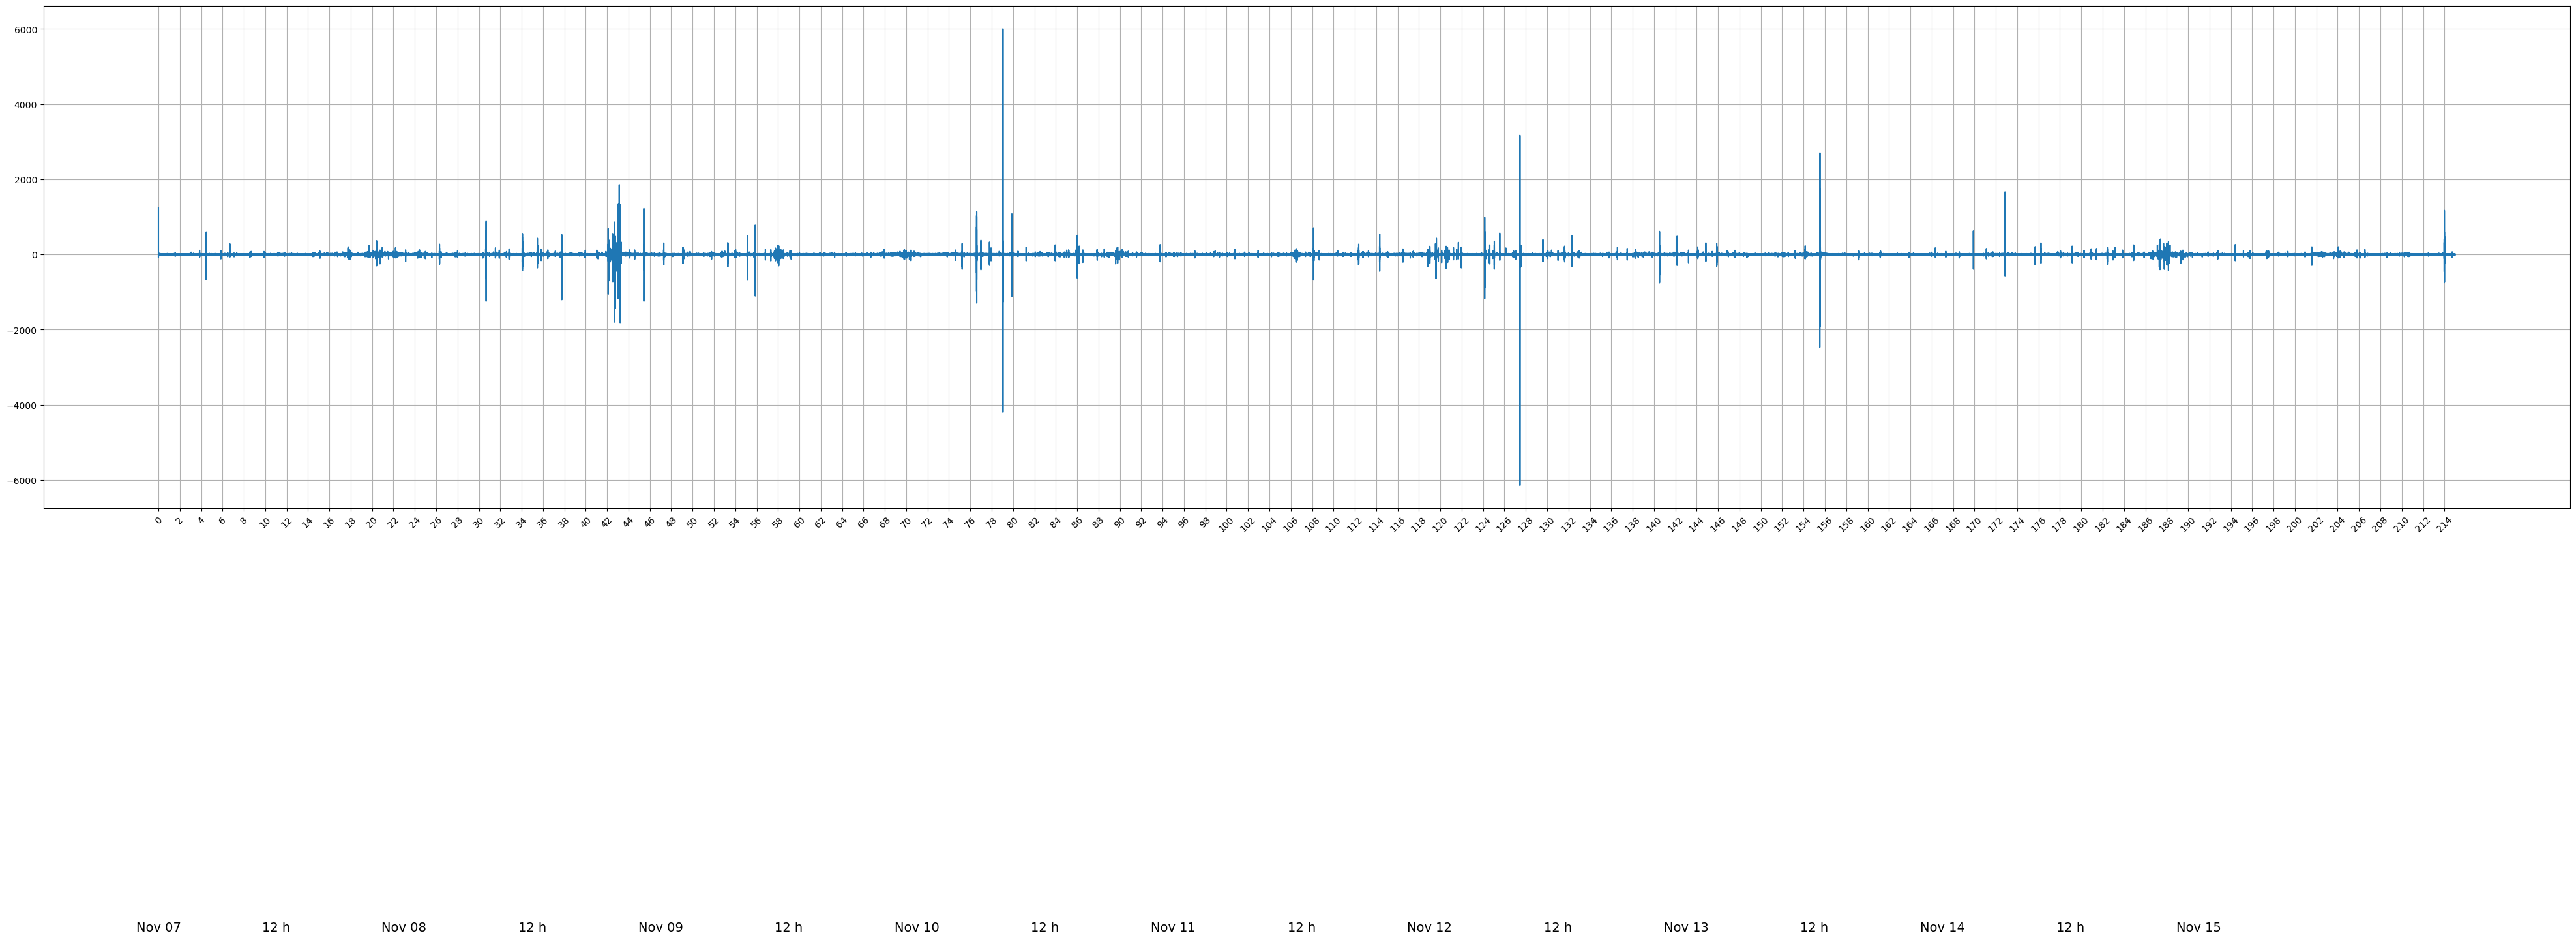

In [76]:
plt.figure(figsize=(50,10))
plt.plot(np.linspace(0,stats.columns[-1],len(tr.data))[0:-1:24],tr.data[0:-1:24])
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Nov 07','12 h','Nov 08','12 h','Nov 09','12 h','Nov 10','12 h','Nov 11','12 h','Nov 12','12 h','Nov 13','12 h','Nov 14','12 h','Nov 15'],ls):
    plt.text(x, -18000, str(i), size=14, ha='center')
plt.grid()
plt.show()

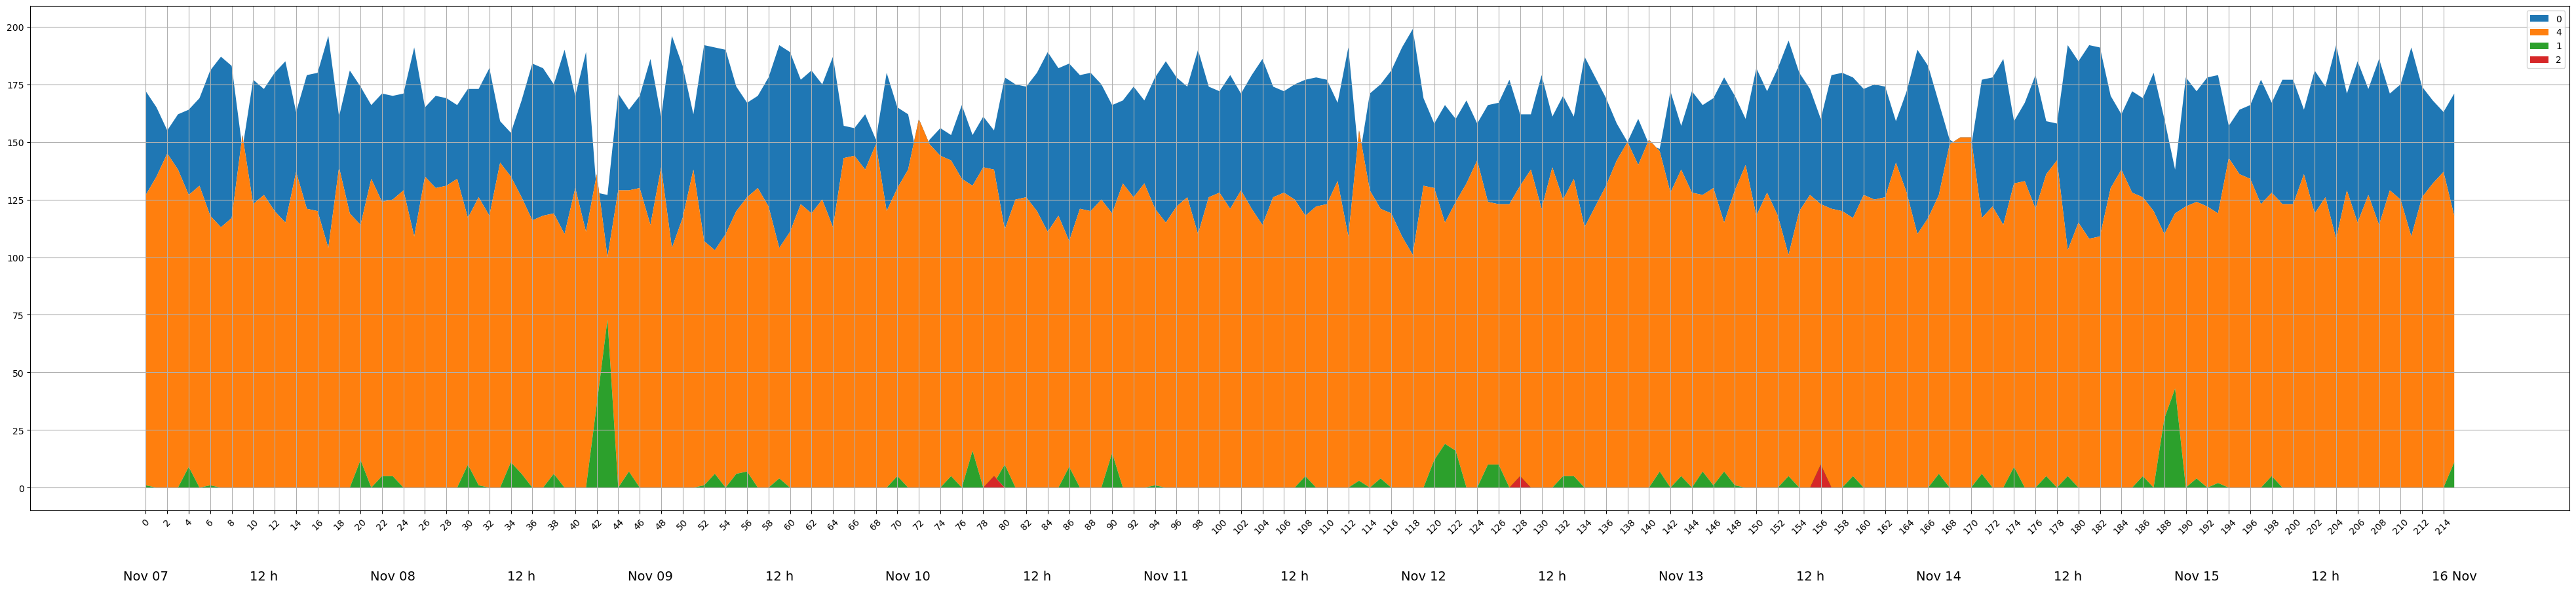

In [77]:
plt.figure(figsize=(50,10))
plt.fill_between(stats.columns,stats.values[0],stats.values[1],label='0')
plt.fill_between(stats.columns,stats.values[1],stats.values[2],label='4')
plt.fill_between(stats.columns,stats.values[2],stats.values[3],label='1')
# plt.fill_between(stats.columns,stats.values[3],stats.values[4],label='3')
plt.fill_between(stats.columns,stats.values[3],0,label='2')
# plt.fill_between(stats.columns,stats.values[4],stats.values[5],label='4')
# plt.fill_between(stats.columns,stats.values[5],stats.values[6],label='5')
# plt.fill_between(stats.columns,stats.values[6],0,label='6')
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Nov 07','12 h','Nov 08','12 h','Nov 09','12 h','Nov 10','12 h','Nov 11','12 h','Nov 12','12 h','Nov 13','12 h','Nov 14','12 h','Nov 15','12 h','16 Nov'],ls):
    plt.text(x, -40, str(i), size=14, ha='center')
plt.grid()
plt.legend()
plt.show()

Text(0, 0.5, 'prfreq')

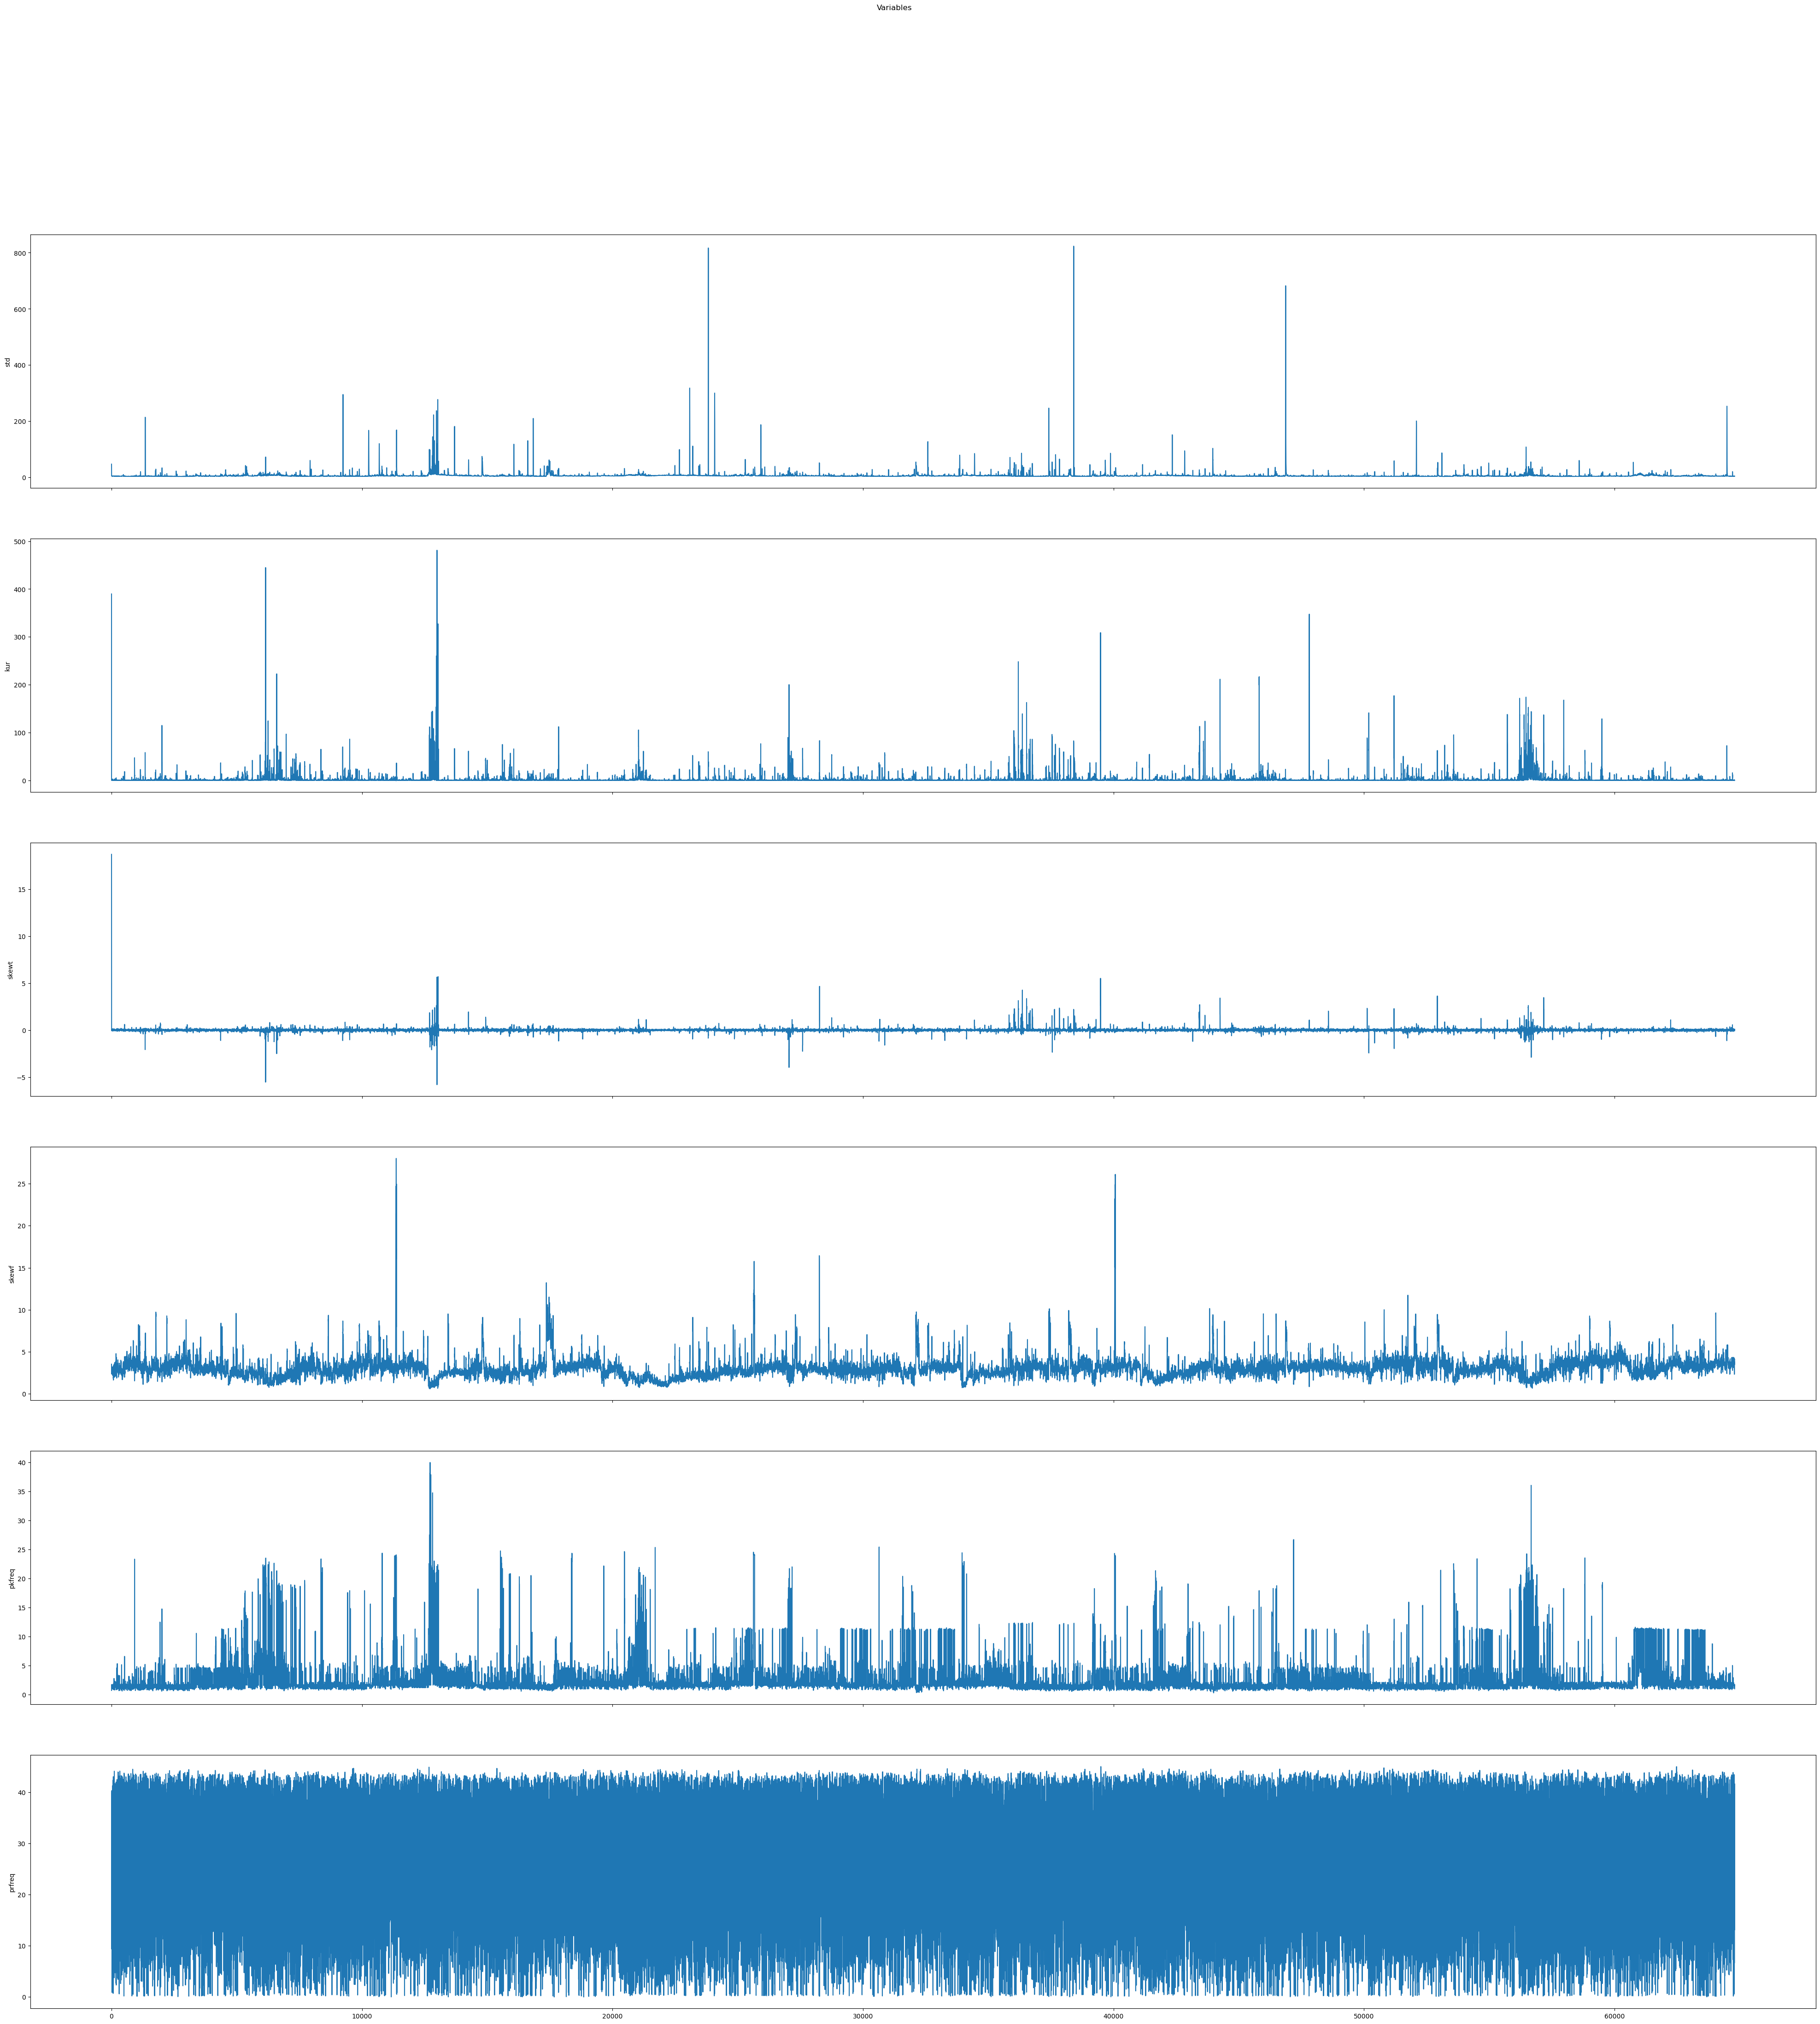

In [78]:
# plt.figure(figsize=(50,10))
fig, axs = plt.subplots(6,sharex=True,figsize=(50,50))
fig.suptitle('Variables')
axs[0].plot(std)
axs[0].set_ylabel('std')
axs[1].plot(kur)
axs[1].set_ylabel('kur')
axs[2].plot(skewt)
axs[2].set_ylabel('skewt')
axs[3].plot(skewf)
axs[3].set_ylabel('skewf')
axs[4].plot(pkfreq)
axs[4].set_ylabel('pkfreq')
axs[5].plot(prfreq)
axs[5].set_ylabel('prfreq')

In [65]:
for i in df['cluster'].unique():
    df1=df[df['cluster']==i]
    print(f'------------------{i}-----------------------')
    print(df1.describe())

------------------3-----------------------
              std         kur       skewt       skewf      pkfreq  cluster
count  565.000000  565.000000  565.000000  565.000000  565.000000    565.0
mean    26.332921   78.242778    0.334512    1.644148   13.425723      3.0
std     20.921692   55.074506    1.580625    0.544202    6.858054      0.0
min      4.762131   25.897215   -5.814223    0.732811    0.716667      3.0
25%     11.256008   48.760008   -0.514122    1.348520    9.200000      3.0
50%     18.914707   61.110043    0.013406    1.583127   16.350000      3.0
75%     32.577998   84.056205    1.158091    1.778321   18.700000      3.0
max     99.475586  481.067528   18.717741    5.945807   36.016667      3.0
------------------1-----------------------
                std           kur         skewt         skewf        pkfreq  \
count  36956.000000  36956.000000  36956.000000  36956.000000  36956.000000   
mean       5.956233      1.287617      0.004192      3.024853      2.510590   
st